In [1]:
import kagglehub
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

In this notebook we will train a convolutional architecture in Pytorch to label brain MRI images with a type of malignancy of types: glioma - meningioma - notumor - pituitary.

The model is fairly easy and used as an exercise of using Integrated Gradients. A method that shows the importance for the classification. For more information see (Sundararajan, 2016)

Axiomatic Attribution for Deep Networks: https://arxiv.org/abs/1703.01365

We also check whether a (less-deep) self trained model shows comparable integrated gradients as a fine-tuned version of ResNet18

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
import torchvision.models as models
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
from typing import List, Tuple

from dataclasses import dataclass
import matplotlib.pyplot as plt
import random
import time
from tqdm.notebook import tqdm

Not all images have the same size. We resize to 512 x 512 resolution

In [9]:
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir: str, transform: transforms.Compose = None, target_size: Tuple[int, int] = (256, 256)): # Downsampling for computational efficiency
        
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size  
        
        self._X: List[torch.Tensor] = []
        self._y: List[int] = []
        self.image_paths: List[str] = [] 
        self.label_map = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
        self.label_map_inv = {v: k for k, v in self.label_map.items()}
        
        self.basic_transform = transforms.Compose([
            transforms.Resize(self.target_size, interpolation=transforms.InterpolationMode.LANCZOS),
            transforms.ToTensor(),
        ])
        
        # Load data into memory
        self._load_data()
    
    def _load_data(self):
        """Loads and preprocesses the dataset."""
        for class_name, label in self.label_map.items():
            class_folder = os.path.join(self.root_dir, class_name)
            if os.path.isdir(class_folder):
                for filename in os.listdir(class_folder):
                    image_path = os.path.join(class_folder, filename)
                    if os.path.isfile(image_path):
                        try:
                            image = Image.open(image_path).convert('RGB')
                            
                            image_tensor = self.basic_transform(image)
                            
                            expected_shape = (3, *self.target_size)
                            if image_tensor.shape != expected_shape:
                                print(f"Error: Tensor shape is {image_tensor.shape}, expected {expected_shape}")
                                continue
                            
                            self._X.append(image_tensor)
                            self._y.append(label)
                            self.image_paths.append(image_path)
                            
                        except Exception as e:
                            print(f"Error processing {image_path}: {str(e)}")
    
    def __len__(self):
        """Returns the number of images in the dataset."""
        return len(self._X)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        """Returns a single image tensor and its corresponding label."""
        image_tensor = self._X[idx]
        label = self._y[idx]
        
        if self.transform:
            image_tensor = self.transform(image_tensor)
        
        return image_tensor, label

    def plot_random_images(self, num_images=4, figsize=(12, 3)):
        """Plot a random sample of images with their labels."""
        fig, axes = plt.subplots(1, num_images, figsize=figsize)
        random_indices = random.sample(range(len(self)), num_images)
        
        for i, idx in enumerate(random_indices):
            image_tensor = self._X[idx] 
            label = self._y[idx]
            
            image_array = image_tensor.permute(1, 2, 0).numpy().clip(0, 1)
            
            ax = axes[i]
            ax.imshow(image_array)
            ax.set_title(f"Label: {self.label_map_inv[label]}")
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()

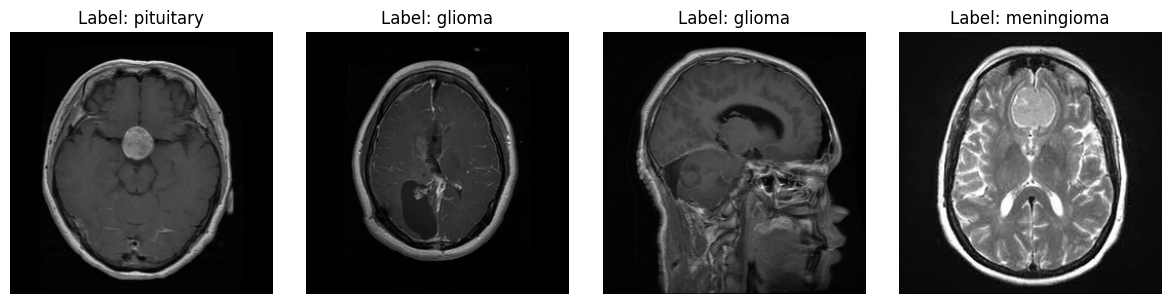

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train = BrainTumorDataset(root_dir='data/brain-tumor-mri-dataset/training', transform=train_transform)
test = BrainTumorDataset(root_dir='data/brain-tumor-mri-dataset/testing', transform=train_transform)

train_loader = DataLoader(dataset=train, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=16, shuffle=True)

train.plot_random_images(num_images=4)

In [11]:
for batch in train_loader:
    break

[item.shape for item in batch]

[torch.Size([16, 3, 256, 256]), torch.Size([16])]

In [35]:
class BrainTumorClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=2),    # 512 -> 254
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=5, stride=5),   # 254 -> 50
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=5, stride=5),   # 50 -> 10
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=5, stride=2),   # 10 -> 3
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16, 4),
            nn.Sigmoid()  
        )

        self.training_accuracy = []
        self.testing_accuracy = []
    
    def forward(self, x):
        return self.model(x)
    
test_model = BrainTumorClassifier().to(device)
test_tensor = torch.randn(1, 3, 256, 256).to(device)
test_model.forward(test_tensor).shape

torch.Size([1, 4])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BrainTumorClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
num_epochs = 200

# model.load_state_dict(torch.load("simple brain cancer convolutional model2.pth"))

In [46]:
pbar = tqdm(range(num_epochs), desc="Training Progress")

for epoch in pbar:
    starting_time = time.time()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    correct = 0 # For testing
    
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions

    # Adding the test accuracy (at the cost of computational speed)
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            correct += (torch.argmax(outputs, 1) == labels).sum().item()
        test_accuracy = correct / len(test_loader.dataset)

    model.training_accuracy.append(epoch_accuracy)
    model.testing_accuracy.append(test_accuracy)

    elapsed_minutes = (time.time() - starting_time) / 60
    log_message = (f"Loss: {epoch_loss:.4f}, "
        f"Train Acc: {epoch_accuracy:.4f}, "
        f"Test Acc: {test_accuracy:.4f}, "
        f"Time: {elapsed_minutes:.1f}m")
    pbar.set_postfix_str(log_message)
    
torch.save(model.state_dict(), "simple_brain_cancer_convolutional_model2.pth")

Training Progress:  34%|███▍      | 68/200 [48:42<1:34:33, 42.98s/it, Loss: 0.7866, Train Acc: 0.9555, Test Acc: 0.8932, Time: 0.6m]


KeyboardInterrupt: 

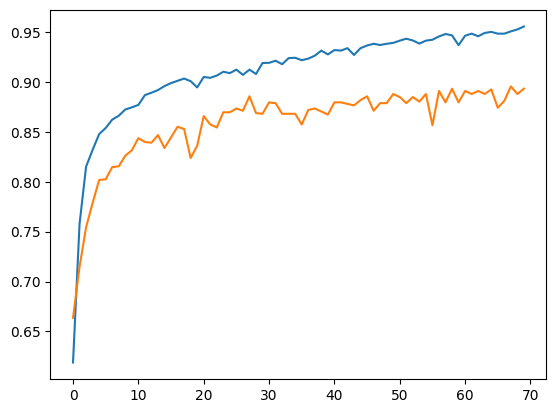

In [51]:
plt.plot(range(70), model.training_accuracy, label='Training Accuracy')
plt.plot(range(70), model.testing_accuracy, label='Testing Accuracy')

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:01<00:00, 25.38it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5179958].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5179958].


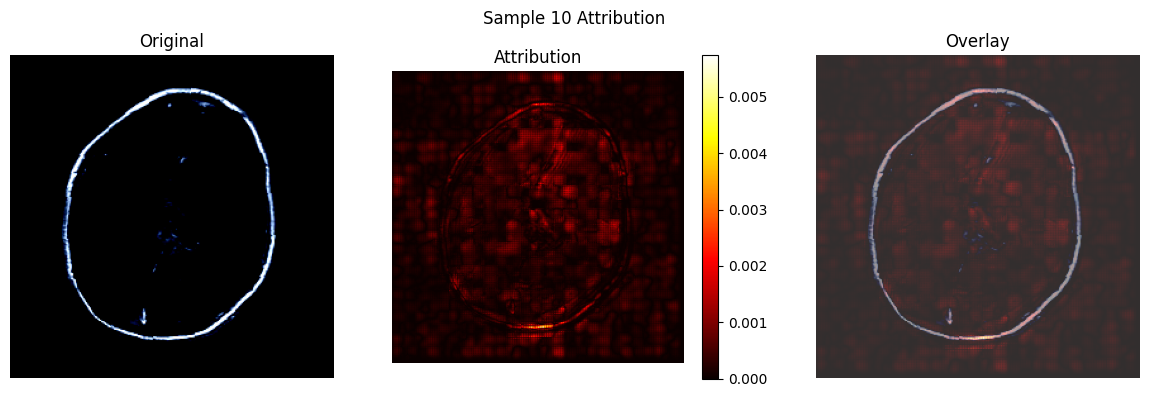

In [58]:
def integrated_gradients(inputs, model, target_class=None, steps=50):
    model.eval()
    device = inputs.device
    
    if target_class is None:
        with torch.no_grad():
            target_class = model(inputs).argmax(dim=1)
    elif isinstance(target_class, int):
        target_class = torch.tensor([target_class] * inputs.size(0), device=device)
    
    baseline = torch.zeros_like(inputs)
    gradients = torch.zeros_like(inputs)
    
    for i in tqdm(range(steps)):
        alpha = (i + 0.5) / steps
        interpolated = baseline + alpha * (inputs - baseline)
        interpolated.requires_grad_(True)
        
        outputs = model(interpolated)
        target_output = outputs.gather(1, target_class.unsqueeze(1)).sum()
        
        grad = torch.autograd.grad(target_output, interpolated)[0]
        gradients += grad
    
    gradients *= (inputs - baseline) / steps
    return gradients

def show_attribution(image, attribution, title="Attribution"):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    # original
    img = image.squeeze().detach().cpu()
    if img.dim() == 3:
        img = img.permute(1, 2, 0)
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    # attribution
    attr = attribution.squeeze().detach().cpu()
    if attr.dim() == 3:
        attr = attr.abs().sum(dim=0)
    else:
        attr = attr.abs()
    
    im = axes[1].imshow(attr, cmap='hot')
    axes[1].set_title('Attribution')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1])
    
    # overlay
    axes[2].imshow(img, cmap='gray', alpha=0.7)
    axes[2].imshow(attr, cmap='hot', alpha=0.4)
    axes[2].set_title('Overlay')
    axes[2].axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# run analysis on random sample
idx = random.randint(0, 15)
ig = integrated_gradients(batch[0], model)
show_attribution(batch[0][idx], ig[idx], f"Sample {idx} Attribution")

Next, we try to use ResNet18 as a foundation model, freeze its weights and use its feature extraction to classify the tumors

In [ ]:
class BrainTumorResNet18(nn.Module):
    def __init__(self):
        super(BrainTumorResNet18, self).__init__()
        # Load ResNet18 and freeze its layers
        self.resnet = models.resnet18(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Get the number of features from the last layer
        num_features = self.resnet.fc.in_features
        
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 4),
            nn.Sigmoid()
        )
        
        self.training_accuracy = []
        self.testing_accuracy = []
        
    def forward(self, x):
        return self.resnet(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.ToTensor(),  # Added ToTensor() - needed for proper tensor conversion
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
model = BrainTumorResNet18()
model = model.to(device)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-3)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 20  
pbar = tqdm(range(num_epochs), desc="Training Progress")
for epoch in pbar:
    starting_time = time.time()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    correct = 0  # For testing
   
    model.train()
    batch_loader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
    for inputs, labels in batch_loader:
        inputs, labels = inputs.to(device), labels.to(device)
       
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
       
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        batch_loader.set_postfix(loss=loss.item())
   
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions
    
    # Adding the test accuracy (at the cost of computational speed)
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            correct += (torch.argmax(outputs, 1) == labels).sum().item()
        test_accuracy = correct / len(test_loader.dataset)
    
    model.training_accuracy.append(epoch_accuracy)
    model.testing_accuracy.append(test_accuracy)
    elapsed_minutes = (time.time() - starting_time) / 60
    log_message = (f"Loss: {epoch_loss:.4f}, "
        f"Train Acc: {epoch_accuracy:.4f}, "
        f"Test Acc: {test_accuracy:.4f}, "
        f"Time: {elapsed_minutes:.1f}m")
    pbar.set_postfix_str(log_message)

# Save model
torch.save(model.state_dict(), "simple_brain_cancer_convolutional_model2.pth")
    
# Plot training and testing accuracy
epochs = range(len(model.training_accuracy))
plt.figure(figsize=(10, 6))
plt.plot(epochs, model.training_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, model.testing_accuracy, 'r-', label='Testing Accuracy')

c:\Users\gouwenss\miniconda3\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gouwenss\miniconda3\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/357 [00:00<?, ?it/s]